<h1 style="color: #FECB05; text-align: center;"> Callbacks</h1>

<h2 style="color: #007ACC;">Autores</h2>

- [Juan Felipe Contreras Alcívar](https://www.linkedin.com/in/juanf-contreras/)

---

<h2 style="color: #007ACC;">Tabla de contenido</h2>

- [<span style="color: #005C99;">Introducción</span>](#introduction)
- [<span style="color: #005C99;">Early Stoping (detener rápido)</span>](#dim-curse)
- [<span style="color: #005C99;">ReduceLROnPlateau (reducción de tasa de aprendizaje)</span>](#dim-curse)
- [<span style="color: #005C99;">LearningRateScheduler (calendario de tasa de aprendizaje)</span>](#dim-curse)
- [<span style="color: #005C99;">Referencias</span>](#reference)

---

<h2 style="color: #007ACC;"> Introducción </h2>

En Deep Learning, los **callbacks** son funciones o herramientas que permiten intervenir en distintos puntos del proceso de entrenamiento de un modelo, como al inicio o al final de una época, después de procesar un lote, o incluso al terminar todo el entrenamiento. Los callbacks son esenciales para monitorizar el progreso, ajustar hiperparámetros dinámicamente, o implementar estrategias avanzadas como el ajuste de la tasa de aprendizaje, el guardado automático del modelo cuando alcanza su mejor desempeño, o la detención temprana si el modelo deja de mejorar. En frameworks como Keras, los callbacks son altamente personalizables y simplifican la gestión del flujo de entrenamiento, permitiendo automatizar tareas y optimizar el proceso de desarrollo del modelo.

<h2 style="color: #007ACC;"> Early Stoping (detener rápido) </h2>

El **Early Stopping** es una técnica que se utiliza para prevenir el sobreajuste y mejorar la eficiencia del entrenamiento de los modelos. Funciona monitorizando una métrica específica (como la pérdida de validación o la precisión) durante el entrenamiento. Si esta métrica deja de mejorar después de un número predefinido de épocas consecutivas (llamado **paciencia**), el entrenamiento se detiene automáticamente.

La lógica detrás de Early Stopping es sencilla: durante el entrenamiento, el modelo mejora su desempeño en el conjunto de entrenamiento, pero esto no siempre implica una mejora en el conjunto de validación. Cuando el modelo comienza a ajustarse demasiado a los datos de entrenamiento (sobreajuste), el desempeño en el conjunto de validación puede estabilizarse o incluso empeorar. Early Stopping identifica este punto y detiene el entrenamiento antes de que el modelo se sobreajuste.

<h3 style="color: #007ACC;">  Proceso de funcionamiento </h3>

**Definir la métrica monitoreada:**
Early Stopping es especialmente útil en tareas donde el sobreajuste es un problema común y donde los recursos computacionales son limitados, ya que evita entrenar el modelo innecesariamente más allá del punto óptimo.

Sea $M(\theta_{i})$ una métrica de validación (p.ej. Accuracy, Entropía Cruzada, MAE, etc), se define:

$$M_{\text{best}} = \min \{ M(\theta_1), M(\theta_2), \dots, M(\theta_t) \}, \quad \text{para métricas a minimizar (ej. pérdida)},$$

$$M_{\text{best}} = \max \{ M(\theta_1), M(\theta_2), \dots, M(\theta_t) \}, \quad \text{para métricas a maximizar (ej. precisión)}.$$


2. **Establecer la paciencia:**

Se define un número de épocas de paciencia $p$. Si no hay mejora en $M(\theta_t)$ durante $p$ épocas consecutivas, el entrenamiento se detiene.

Para cada época $t$, evaluamos si se cumple:

$$\vert M(\theta_t) - M_{\text{best}} \vert < \epsilon, \quad \forall \, t' \in [t-p, t]$$

donde $\epsilon$ es un umbral opcional que define la tolerancia para cambios insignificantes.


3. **Criterio de detención:**
Si el modelo no mejora después de $p$ épocas consecutivas, se detiene el entrenamiento:

$$t_{\text{stop}} = t \quad \text{si} \quad M(\theta_t) \geq M_{\text{best}} \quad \text{durante \( p \) épocas consecutivas.}$$

Para evitar la pérdida de progreso, se restauran los parámetros del modelo a aquellos correspondientes a la época $t_{\text{best}}$, donde se alcanzó $M_{\text{best}}$:

$$\theta_{\text{final}} = \theta_{t_{\text{best}}}.$$


<h3 style="color: #007ACC;">  Ejemplo con Tensorflow: datos de simulación </h3>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

In [2]:
# Generar datos sintéticos
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
y = y.reshape(-1, 1)  # Asegurarse de que la salida tenga la forma correcta

In [3]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Crear el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Salida para un problema de regresión
])

In [5]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
# Definir el callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=8,         # Número de épocas de paciencia
    restore_best_weights=True,  # Restaurar los pesos del mejor modelo
    verbose=1            # Mostrar mensajes durante el entrenamiento
)

In [20]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Número máximo de épocas
    batch_size=32,
    callbacks=[early_stopping]  # Incluir el callback de Early Stopping
)

Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2887 - mae: 0.4302 - val_loss: 2.9936 - val_mae: 1.2464
Epoch 2/100
25/25 [==============================] - 0s 965us/step - loss: 0.3324 - mae: 0.4540 - val_loss: 3.0300 - val_mae: 1.3052
Epoch 3/100
25/25 [==============================] - 0s 957us/step - loss: 0.3274 - mae: 0.4527 - val_loss: 3.0127 - val_mae: 1.2778
Epoch 4/100
25/25 [==============================] - 0s 967us/step - loss: 0.3454 - mae: 0.4594 - val_loss: 3.1865 - val_mae: 1.3059
Epoch 5/100
25/25 [==============================] - 0s 961us/step - loss: 0.2938 - mae: 0.4305 - val_loss: 2.9656 - val_mae: 1.2540
Epoch 6/100
25/25 [==============================] - 0s 959us/step - loss: 0.3126 - mae: 0.4434 - val_loss: 2.9849 - val_mae: 1.3094
Epoch 7/100
25/25 [==============================] - 0s 942us/step - loss: 0.3409 - mae: 0.4729 - val_loss: 2.9459 - val_mae: 1.2856
Epoch 8/100
25/25 [==============================] - 0s 953us/step - lo

In [21]:
# Evaluar el modelo en los datos de validación
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

7/7 [==============================] - 0s 756us/step - loss: 2.5408 - mae: 1.1696
Validation Loss: 2.5408318042755127, Validation MAE: 1.1695928573608398


In [22]:
import matplotlib.pyplot as plt

# Función para graficar las curvas de entrenamiento
def plot_training_curves(history):
    """
    Graficar las curvas de pérdida y métrica durante el entrenamiento.
    
    Args:
        history: El objeto History devuelto por model.fit().
    """
    # Extraer datos del historial
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Graficar la pérdida
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
    plt.plot(epochs, val_loss, label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid()
    plt.show()

    # Verificar si hay métricas adicionales
    if 'mae' in history.history:
        mae = history.history['mae']
        val_mae = history.history['val_mae']
        
        # Graficar la métrica
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, mae, label='MAE de Entrenamiento')
        plt.plot(epochs, val_mae, label='MAE de Validación')
        plt.title('MAE durante el Entrenamiento y Validación')
        plt.xlabel('Épocas')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid()
        plt.show()

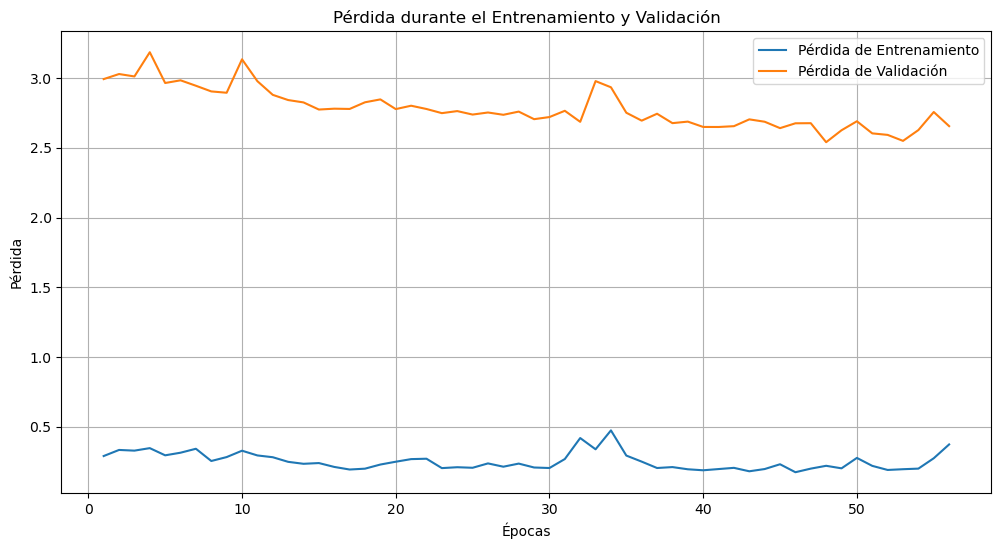

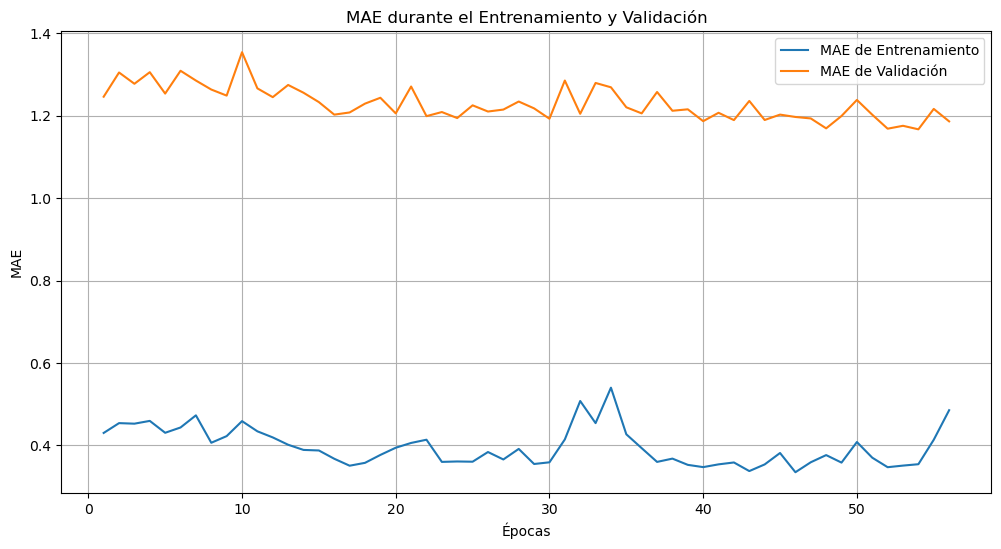

In [23]:
plot_training_curves(history)

<h2 style="color: #007ACC;"> ReduceLROnPlateau (reducción de tasa de aprendizaje)</h2>

ReduceLROnPlateau es un callback que ajusta dinámicamente la tasa de aprendizaje (learning rate) durante el entrenamiento de un modelo. La tasa de aprendizaje es un hiperparámetro clave que controla el tamaño de los pasos realizados durante la optimización. Este callback es especialmente útil para evitar que el modelo quede atascado en mínimos locales o para mejorar la convergencia cuando la métrica de interés deja de mejorar.

<h3 style="color: #007ACC;">  Proceso de funcionamiento </h3>

1. **Tasa de aprendizaje inicial**
Al inicio del entrenamiento, el modelo tiene una tasa de aprendizaje inicial:

$$\eta_0 = \text{learning rate inicial definida por el usuario}.$$

2. **Criterio de monitoreo**
El callback monitorea una métrica $M(\theta_t)$, donde $\theta_t$ son los parámetros del modelo en la época $t$.

3. **Condición de no mejora**
Se considera que no hay mejora en $M(\theta_t)$ si cumple la condición:

$$ \vert M(\theta_t) - M_{\text{best}} \vert < \epsilon, \quad \forall t' \in [t-p, t],$$

donde:
- $ M_{\text{best}} $ es el mejor valor observado de la métrica hasta la época $t$,
- $p$ es la paciencia ($\textit{patience}$) en épocas,
- $\epsilon$ es un umbral opcional de tolerancia.

4. **Ajuste de la tasa de aprendizaje**

Si no hay mejora en $M(\theta_t)$ durante $p$ épocas consecutivas, se reduce la tasa de aprendizaje $\eta_t$ multiplicándola por un factor $\lambda$, donde $0 < \lambda < 1$. Matemáticamente:

$$\eta_{t+1} = \eta_t \cdot \lambda, \quad \text{si no mejora en \( p \) épocas}.$$

El proceso se repite cada $p$ épocas mientras no haya mejora.

5. **Valor mínimo de la tasa de aprendizaje**
El valor de la tasa de aprendizaje nunca se reducirá por debajo de un mínimo definido por el usuario $\eta_{\text{min}}$:

$$\eta_t = \max(\eta_t, \eta_{\text{min}}).$$

Esto asegura que el modelo pueda seguir ajustándose aunque sea con pasos muy pequeños.

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [25]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1
)

In [26]:
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[reduce_lr]
)

Epoch 1/50
25/25 [==============================] - 0s 2ms/step - loss: 0.2294 - mae: 0.3778 - val_loss: 2.6725 - val_mae: 1.1830 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 0s 1ms/step - loss: 0.2734 - mae: 0.4157 - val_loss: 2.5717 - val_mae: 1.1751 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 0s 977us/step - loss: 0.1973 - mae: 0.3536 - val_loss: 2.6629 - val_mae: 1.1861 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 0s 933us/step - loss: 0.2028 - mae: 0.3578 - val_loss: 2.6111 - val_mae: 1.1609 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.1981 - mae: 0.3544 - val_loss: 2.6092 - val_mae: 1.1482 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 0s 986us/step - loss: 0.2238 - mae: 0.3696 - val_loss: 2.7243 - val_mae: 1.1896 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 0s 938us/step - loss: 0.1992 - mae: 0.3539 - val_loss: 2.5702 - val_mae: 1.1661 - lr

<h2 style="color: #007ACC;"> LearningRateScheduler (calendario de tasa de aprendizaje)</h2>

El LearningRateScheduler es un callback que permite ajustar dinámicamente la tasa de aprendizaje, $𝜂$, en cada época durante el entrenamiento del modelo, siguiendo una estrategia predefinida o una función personalizada. Esto es útil porque la tasa de aprendizaje óptima puede variar en diferentes etapas del entrenamiento: valores altos al principio permiten explorar rápidamente el espacio de soluciones, mientras que valores bajos en etapas posteriores ayudan a refinar los resultados.

<h3 style="color: #007ACC;">  Proceso de funcionamiento </h3>

1. **Definición de la función:** El usuario proporciona una función que calcula la nueva tasa de aprendizaje en función del número de época actual. La función puede ser lineal, exponencial, basada en hitos (por ejemplo, decay constante cada N épocas), o completamente personalizada.

2. **Actualización por época:** Al comienzo de cada época, el callback calcula la nueva tasa de aprendizaje, $𝜂$, utilizando la función proporcionada.

3. **Aplicación de la nueva tasa:** La nueva tasa de aprendizaje reemplaza la tasa anterior en el optimizador del modelo, influenciando el tamaño de los pasos del gradiente descendente.

<h3 style="color: #007ACC;"> Estrategias comunes de programación del learning rate </h3>

- Decaimiento constante: Reduce la tasa de aprendizaje en cada época por un factor fijo:

$$\eta_{t} = \eta_{o} \left(1 - \frac{t}{T}\right)$$

donde $T$ es el número total de épocas.

- Decaimiento exponencial: La tasa de aprendizaje disminuye exponencialmente:

$$\eta_{t} = \eta_{0} e^{-kt}$$

donde $k$ es una constante de decaimiento.

- Step decay: Reduce la tasa de aprendizaje en puntos específicos (escalones):

$$\eta_{t} = \eta_{0} \lambda^{t/step}$$

donde $\lambda$ es un factor de reducción y $\text{step}$ es el intervalo de épocas.

- Cosine Annealing: Oscila la tasa de aprendizaje siguiendo una curva coseno, útil en estrategias avanzadas como el reinicio de aprendizaje cíclico.

In [27]:
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

In [28]:
# Definir la función de programación del learning rate
def lr_schedule(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** (epoch // epochs_drop))

In [29]:
# Crear el callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

In [30]:
# Modelo simple
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(1)
])

In [31]:
# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse')

In [32]:
# Entrenar el modelo con el callback
history = model.fit(X_train, y_train, epochs=50, callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
25/25 [==============================] - 0s 525us/step - loss: 16920.8477 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
25/25 [==============================] - 0s 499us/step - loss: 13713.1221 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
25/25 [==============================] - 0s 462us/step - loss: 7729.5933 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
25/25 [==============================] - 0s 462us/step - loss: 2529.5591 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
25/25 [==============================] - 0s 448us/step - loss: 591.0698 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/50
25/25 [==============================] - 0s 423us/step - loss: 325.3694 - lr: 0.0100

Epoch 7: LearningRateScheduler setting 

<h2 style="color: #007ACC;"> Referencias </h2>

- Documentación oficial de Keras: https://keras.io/api/callbacks/
- Definición personalizada de callbacks en Tensorflow: https://www.tensorflow.org/guide/keras/writing_your_own_callbacks